In [1]:
import os
import gc
import csv
import sys
import ast
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.grid_search import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer

csv.field_size_limit(sys.maxsize)
os.chdir('../Data/Seattle/')
pd.options.display.max_columns = 999

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
# Code modified from https://github.com/rayidghani/magicloops

def define_clfs_params(grid_size):
    """Define defaults for different classifiers.
    Define three types of grids:
    Test: for testing your code
    Small: small grid
    Large: Larger grid that has a lot more parameter sweeps
    """

    clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
        'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
        'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
        'LR': LogisticRegression(penalty='l1', C=1e5),
        'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
        'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
        'NB': GaussianNB(),
        'DT': DecisionTreeClassifier(),
        'SGD': SGDClassifier(loss="hinge", penalty="l2"),
        'KNN': KNeighborsClassifier(n_neighbors=3) 
            }

    large_grid = { 
    'RF':{'n_estimators': [1,10,100,1000,10000], 'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.0001,0.001,0.01,0.1,0.5,1,10]},
    'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [1,10,100,1000,10000], 'criterion' : ['gini', 'entropy'] ,'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10], 'n_jobs': [-1]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [1,10,100,1000,10000], 'learning_rate' : [0.001,0.01,0.05,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [1,3,5,10,20,50,100]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }
    
    small_grid = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,0.5, 1,10]},
    'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [10,100], 'criterion' : ['gini', 'entropy'] ,'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [10,100], 'learning_rate' : [0.001,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [5,50]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }
    
    test_grid = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'SGD': { 'loss': ['perceptron'], 'penalty': ['l2']},
    'ET': { 'n_estimators': [1], 'criterion' : ['gini'] ,'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'NB' : {},
    'DT': {'criterion': ['gini'], 'max_depth': [1],'min_samples_split': [10]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}
           }
    
    if (grid_size == 'large'):
        return clfs, large_grid
    elif (grid_size == 'small'):
        return clfs, small_grid
    elif (grid_size == 'test'):
        return clfs, test_grid
    else:
        return 0, 0
    
def joint_sort_descending(l1, l2):
    # l1 and l2 have to be numpy arrays
    idx = np.argsort(l1)[::-1]
    return l1[idx], l2[idx]

def generate_binary_at_k(y_scores, k):
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary

def precision_at_k(y_true, y_scores, k):
    y_scores, y_true = joint_sort_descending(np.array(y_scores), np.array(y_true))
    preds_at_k = generate_binary_at_k(y_scores, k)
    precision = precision_score(y_true, preds_at_k)
    return precision

def plot_precision_recall_n(y_true, y_prob, model_name):
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_xlim([0,1])
    
    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()

def get_feature_importance(clf, model_name):
    clfs = {'RF':'feature_importances',
            'LR': 'coef',
            'SVM': 'coef',
            'DT': 'feature_importances',
            'KNN': None,
            'AB': 'feature_importances',
            'GB': 'feature_importances',             
            'linear.SVC': 'coef',
            'ET': 'feature_importances',
            'NB': None
            }

    if clfs[model_name] == 'feature_importances':
        return  list(clf.feature_importances_)
    elif clfs[model_name] == 'coef':
        return  list(clf.coef_.tolist())
    else:
        return None

def clf_loop(df, models_to_run, clfs,balanced=True, features_groups =['BASE', 'BASE+NGRAM', 'BASE+TM', 'ALL']):
    """Runs the loop using models_to_run, clfs, gridm and the data
    """
    results_df =  pd.DataFrame(columns=('features_group','model_type','clf', 'parameters', 'MSE','auc-roc',
                                        'p_at_1','p_at_2','p_at_5', 'p_at_10','p_at_20',
                                        'cv_avg_precision', 'accuracy','f1_score', 'precision', 'recall', 
                                        'feature_importances'))
    cols = list(df.columns)
    features_cols = {'BASE': cols[0:97], 'BASE+NGRAM': cols[0:97] + cols[137:-1], 'BASE+TM' : cols[0:137], 'ALL':cols[:-1]}
    models = {}
    data = {}
    
    y = df.label
    
    for features_group in features_groups:
        
        X = df[features_cols[features_group]]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                            random_state=0)
        # Save training and test data 
        data = {'X_train':X_train, 'X_test':X_test,'y_train':y_train,'y_test':y_test}
        # Balance data
        if balanced:
            X_train, y_train = SMOTE().fit_sample(X_train, y_train)

        for index,clf in enumerate([clfs[x] for x in models_to_run]):
            print(models_to_run[index])
            parameter_values = grid[models_to_run[index]]
            for p in ParameterGrid(parameter_values):
                try:
                    clf.set_params(**p)
                    fitted_model = clf.fit(X_train, y_train)
                    # Save models 
                    models[str(models_to_run[index])+"-"+str(p)] = fitted_model
                    y_pred_probs = fitted_model.predict_proba(X_test)[:,1]
                    y_pred = fitted_model.predict(X_test)
                    mse = mean_squared_error(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    f1 = f1_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    recall = recall_score(y_test, y_pred)
                    cv_scores = cross_val_score(clf, X, y, cv=5,scoring='average_precision')

                    y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))
                    results_df.loc[len(results_df)] = [features_group, models_to_run[index],clf, p,mse,
                                                       roc_auc_score(y_test, y_pred_probs),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,1.0),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,2.0),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,20.0),
                                                       cv_scores.mean(),
                                                       accuracy, f1, precision, recall,
                                                       get_feature_importance(clf, models_to_run[index])]
                    plot_precision_recall_n(y_test,y_pred_probs,clf)
                except IndexError as e:
                    print('Error:',e)
                    continue

    filename = 'ml_results_cv'
    if not balanced:
        filename +="_imbalanced"
    results_df.to_csv(filename +'.csv', index=False)
    return (models,data)

In [7]:
df = pd.read_csv('features_table.csv', index_col=0)

LR


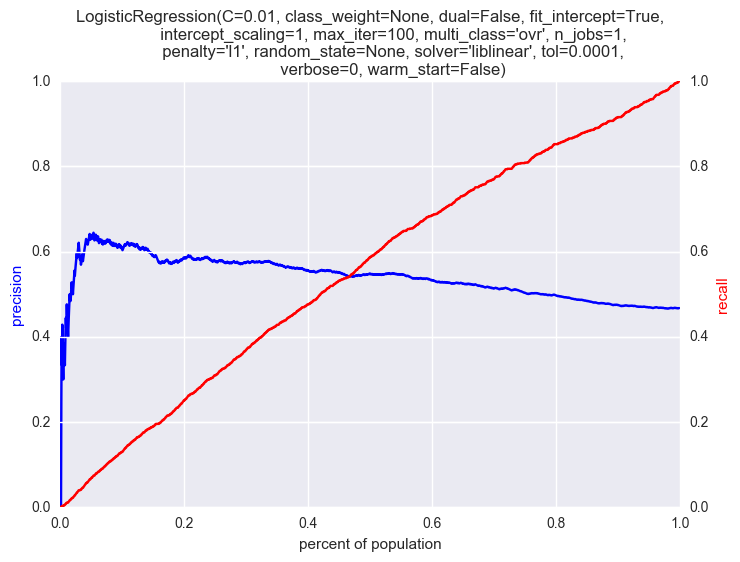

LR


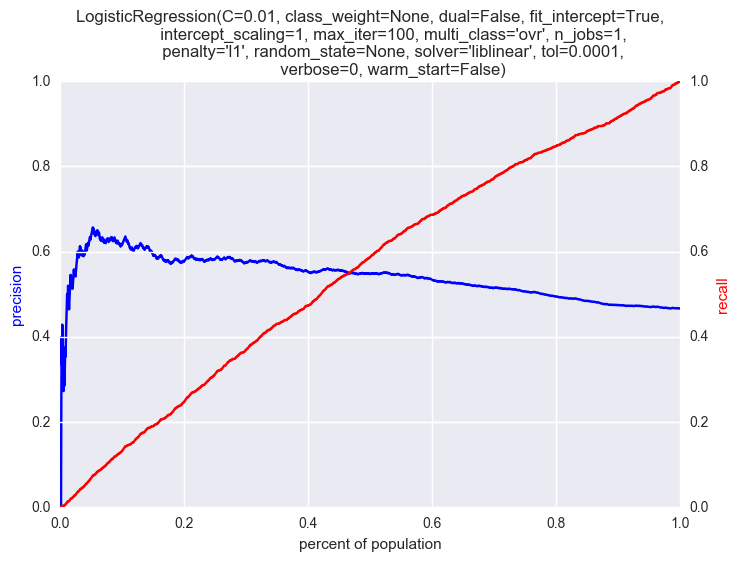

LR


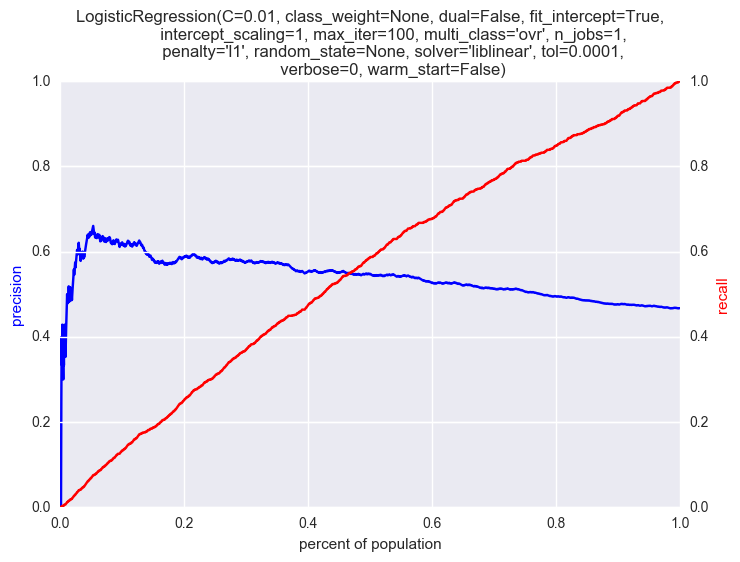

LR


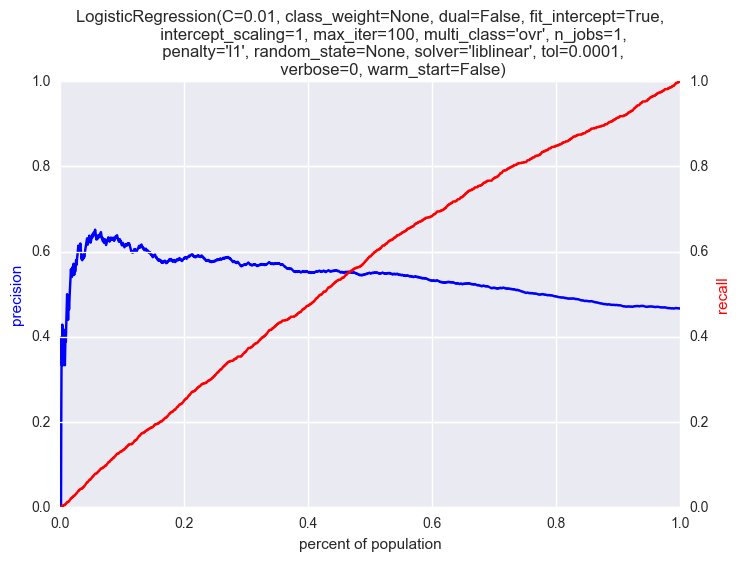

In [8]:
# define grid to use: test, small, large
grid_size = 'test'
clfs, grid = define_clfs_params(grid_size)

# define models to run
models_to_run=['LR']

# define features
features_groups =['BASE', 'BASE+NGRAM', 'BASE+TM', 'ALL']

# call clf_loop for balanced data
results = clf_loop(df, models_to_run, clfs, grid, features_groups)